# Introduction

This document constitutes the submission for the first assigment in Advanced Optimization and Decision Analytics course in MSc in Statistics for Data Science @UC3M. The main goal is solving some given tasks revolving a binary classification logistic model. We assume the reader is familiarized with general convex optimization and iterative algorithms, as well as basic regression knowledge. The tasks try to progressively implement more and more 'by hand' methods to numerically solve the estimation of the model parematers in the logit model, as well to cover some different approaches to this problem.

## Description of the model

Assume that we have collected binary observations $x \in \mathbb{R}^p$. This means we have $p$ observed values for each individual, and the individuals either belong to two different classes, $A$ and $B$. We will codify these classes using the variable $y$, so that $y=1$ if $x$ belongs to class $A$, and $y=0$ if $x$ belongs to class $B$.

Our goal is to estimate the probability of an observation belonging to either class A or B given the data. This is: $P(y=1|x)$ or $P(y=0|x)$. If we define a threshold $\epsilon \in (0,1)$ (typically .5) so that if  $P(y=1|x) \geq \epsilon$ then $x$ belongs to class $A$ and if not then it belongs to class $B$, we obtain our desired classification.

To do so, the logistic model generalizes the idea of linear regression and attempts to classify our data based on what it is called a linear predictor. We will try to find, if it exists, the linear function:

$$x \beta^T=\beta_0+\beta_1 x_1+\cdots+\beta_p x_p,$$

being $x=(1,x_1,\ldots, x_p)$ the observations and $\beta=(\beta_0, \ldots, \beta_p)$ a set of $p+1$ unknown coefficients. 

The model takes this (continuous) real number $x \beta^T$ and transforms it into the interval $[0,1]$ in order to represent a probability. The most common transformation used in logit models is given by the sigmoid function:

\begin{equation} \label{eq:1}
\hat{y}=\frac{1}{1+\exp \left(-x\beta^T\right)} \equiv \varphi(\beta ; x)
\end{equation}

This way, values close to 1 (large positive scalars in the linear function) should indicate a high probability for an observation to belong to class $A$, and values close to 0 (large negative scalars in the linear function) should indicate observations belong to $B$ with high probability.

Now we have an estimation for $y$ as $\hat{y}$ we can obtain $P(\hat{y}=1|x)$ and compare it with $\epsilon$ to classify the observation.

So in order to correctly apply our model to some given data, the only unknown part in the model (what we will aim to optimize) is the linear coefficients vector $\beta$.

### Optimal $\beta$ estimation

The estimation of the coefficients is done via solving an optimization problem based on **maximum likelihood**. Maximum likelihood optimization is a method to estimate the parameters of a statistical model ($\beta$ in our case) by maximizing the *likelihood function*, which measures the probability of observing the data given the model's parameters. This way we  find the parameter values that make the observed data most probable under the model.

Given a sample of values (observation and classes) in the previously commented setup $\left\{\left(x_i, y_i\right)\right\}_{i-1}^n$, the maximization for $\beta$ in the *log-likelihood function* is:

\begin{equation} \label{eq:2}
\max _\beta \sum_{i=1}^n y_i \log \varphi\left(\beta ; x_i\right)+\sum_{i=1}^n\left(1-y_i\right) \log \left(1-\varphi\left(\beta ; x_i\right)\right) .
\end{equation}


# Assignment tasks

We will solve the following tasks using Python 3.11.4. The required libraries are loaded now.


In [4]:
import numpy as np
from sklearn import linear_model, metrics
from scipy.optimize import minimize
import time
import warnings
import matplotlib.pyplot as plt

## Task A

*Generate random data $\left\{\left(x_i, y_i\right)\right\}_{i-1}^n$ to be latter used to adjust the logistic model. Set the number of observations to generate as $n=1000$, and the number of variables for each observation as $p=20$.*

In [5]:
p = 20
n = 1000

# Random seed in order to have the same results always
np.random.seed(1234)

# Generate random beta vector
beta = np.random.randint(-10, 10, size=p+1)

# Generate feature matrix X_0 with standard normal
X_0 = np.random.randn(n, p)
# Adding a column of ones to account for the intercept term
X = np.concatenate((np.ones((n,1)), X_0), axis=1)

# Create linear predictor
linPred = np.dot(X, beta)

# Introduce some random error. Scale may be adjustable
linPred_error = linPred + np.random.normal(loc=0, scale=0.1, size=len(linPred))

# Create the sigmoid (logit) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Compute phi
phi = sigmoid(linPred_error)

# Create the binary sample y_hat using phi as probabilities
y= np.random.binomial(n=1, p=phi)

# Our sample is now (X, y)
print('The true beta values are: ', beta)

The true beta values are:  [ 5  9 -4  2  5  7 -1  1  2  6 -5  6 -1  5  8  6  2 -5 -8 -4 -7]


## Task B

*Using the generated dataset, compute the regression coefficients with `Sklearn`.*

In [6]:
# Create the logit regression objetc using Sklearn function
LogRegr = linear_model.LogisticRegression(fit_intercept=False,penalty=None)

# We fit the model for our sample.
model1 = LogRegr.fit(X,y)

# The coefficients:
print("Estimated Sklearn coefficients:\n", model1.coef_[0])

Estimated Sklearn coefficients:
 [  6.56926652  12.52005982  -5.65183298   2.37371959   6.23835067
   9.35581382  -1.23222534   1.46485045   3.52646744   8.40319957
  -7.46924553   8.41250048  -2.06521167   7.55484684  10.90570441
   8.49554347   3.49909793  -7.0671088  -10.33491663  -5.80597179
  -9.10457705]


We can compute the **Mean Absolute Error (MAE)** between the real values and SkLearn estimation to see how good (or bad) the estimation is. This is:

In [7]:
MAE_1 = metrics.mean_absolute_error(beta, model1.coef_[0])

# Error with the true values
print('MAE between the real values and SkLearn estimation is:\n', MAE_1)

MAE between the real values and SkLearn estimation is:
 1.8595481340935482


Note that this provides the solution to *maximum likelihood problem* \ref{eq:2}. This fast implementation by `Sklearn` will be used as a benchmark for the following tasks.

## Task C

*Estimate the value of the regression coefficients from \ref{eq:2} by using the function minimize from the Python module `Scipy.optimize`. Choose three different solution algorithms `('method')` and compare their performance (number of iterations, function and gradient evaluations and computational times).*

Several numerical methods exist in the scientific literature in order to solve for \ref{eq:2}. Package `Scipy` implements some of the most important ones that we have studied during the course via `Scipy.optimize.minimize`. This function requires a variety of parameters to sucessfully minimize a given callable. In order to correctly understand all the (vast) options the library gives us please read the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). The most important thing about this documentation is that we will need three things in order to solve \ref{eq:2}:

- First we need an objective function. Since our initial problem is a maximization and we want to minimize, our objective function will be the minimization of the **Negative Log-Likelihood** given by:
\begin{equation} \label{eq:3}
\min _\beta -(\sum_{i=1}^n y_i \log \varphi\left(\beta ; x_i\right)+\sum_{i=1}^n\left(1-y_i\right) \log \left(1-\varphi\left(\beta ; x_i\right)\right)) .
\end{equation}

In [8]:
# Negative Log-Likelihood function
def neg_log_l(beta, X, y):
    # Compute the predicted probabilities
    y_pred = sigmoid(np.dot(X, beta.T))
    
    # Clip the predicted probabilities to avoid extreme values
    y_pred = np.clip(y_pred, 1e-3, 1 - 1e-3)
    
    # Compute the negative log-likelihood
    f = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    return f

# Please note that when performing np.dot(matrix, column vector), 
# thanks to broadcasting what we get is a column vector.

- Since negative log-likelihood does not guarantee convexity[^1], we cannot have closed-form solutions like linear regression. Therefore, we can use numerical methods (like gradient methods or Newton or Quasi-Newton's methods) in order to iteratively compute this (local) optimal solution. Numerical methods always need of one first iteration point, this is the initial guess $x_0$.

[^1]: We assume the reader is familiarized with the [importance of convexity in optimization problems](https://en.wikipedia.org/wiki/Convex_optimization).


In [9]:
# Initial guess for coefficients
initial_guess = np.zeros(X.shape[1])

- You can check alll the available methods in the package documentation mentioned above. Please note how several of these methods require other parameter that is the gradient function (and/or Hessian matrix). The `Scipy` module allows us to give the gradient and Hessian functions as callables or to approximate this derivative values by several numerical methods. Since both functions are known for our particular case, we will code them as functions[^2].

[^2]: See [this document](http://gauss.stat.su.se/phd/oasi/OASII2021_gradients_Hessians.pdf) for the calculations. Please note how we have inverted the dimension notation for the beta's and X's.

In [10]:
# Gradient of the Negative Log-Likelihood
def neg_log_l_gradient(beta, X, y):
    return np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y.T)


# Hessian of the Negative Log-Likelihood
def neg_log_l_hessian(beta, X, y):
    z = np.dot(X, beta.T)
    sig = sigmoid(z)
    return np.dot(X.T, np.dot(np.diag(sig * (1 - sig)), X))

Now we have all our possible parameters, we will select one method for each type we have seen in course lectures. One Gradient method (Conjugate Gradient), one Newton Method (Newton Conjugate Gradient) and one Quasi-Newton method (BFGS). Note how the Hessian is only required for the Newton Method. We will used a convergence tolerance of $1\times10^{-3}$ in all methods, as well as a miximum number of iterations of $1000$.

### Gradient method

The `scipy.optimize` gradient method can be implemented as follows.

In [11]:
# Optimization using CG method
start_time = time.time()
result_CG = minimize(
    neg_log_l,
    initial_guess,
    args=(X, y),
    jac=neg_log_l_gradient,
    method="CG",
    options={"maxiter": 1000},
    tol=1e-3,
)
end_time = time.time()
elapsed_time_CG = end_time - start_time

print("Optimization method: Conjugate Gradient (CG)")
print("Number of iterations:", result_CG.nit)
print("Number of function and gradient evaluations:", result_CG.nfev)
print("Computational time (seconds):", elapsed_time_CG)
print("Estimated coefficients:", result_CG.x)
print("MAE with real betas: ", metrics.mean_absolute_error(result_CG.x, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(result_CG.x, model1.coef_[0]))

Optimization method: Conjugate Gradient (CG)
Number of iterations: 59
Number of function and gradient evaluations: 152
Computational time (seconds): 0.06766343116760254
Estimated coefficients: [  6.47252522  12.34305467  -5.57246107   2.33974958   6.14613482
   9.22837206  -1.21591597   1.44497232   3.47775908   8.28193496
  -7.35952561   8.29195567  -2.03727076   7.44593947  10.7462081
   8.37279978   3.44696486  -6.96267087 -10.18760078  -5.72324903
  -8.9727209 ]
MAE with real betas:  1.7652278839653508
MAE with Sklearn betas estimation:  0.09432025012819777


### Newton method

The Newton Method implemented in `Scipy` is the following:

In [12]:
start_time = time.time()
result_N = minimize(
    neg_log_l,
    initial_guess,
    args=(X, y),
    jac=neg_log_l_gradient,
    hess=neg_log_l_hessian,
    method="Newton-CG",
    options={"maxiter": 1000},
    tol=1e-3,
)
end_time = time.time()
elapsed_time_N = end_time - start_time

print("Optimization method: Newton-CG")
print("Number of iterations:", result_N.nit)
print("Number of function and gradient evaluations:", result_N.nfev)
print("Computational time (seconds):", elapsed_time_N)
print("Estimated coefficients:", result_N.x)
print("MAE with real betas: ", metrics.mean_absolute_error(result_N.x, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(result_N.x, model1.coef_[0]))

Optimization method: Newton-CG
Number of iterations: 13
Number of function and gradient evaluations: 39
Computational time (seconds): 0.12313985824584961
Estimated coefficients: [  6.53614627  12.46068193  -5.62482541   2.36230028   6.20726175
   9.31275695  -1.22691287   1.4583707    3.51073512   8.36235964
  -7.43254335   8.37230805  -2.05587719   7.51812794  10.85150734
   8.45403634   3.48104812  -7.03202395 -10.28512538  -5.77781759
  -9.06013361]
MAE with real betas:  1.8277571324317745
MAE with Sklearn betas estimation:  0.031791001661773746


### Quasi-Newton method

The BFGS, one of the most common Quasi-Newton methods is implemented as:

In [13]:
start_time = time.time()
result_BFGS = minimize(
    neg_log_l,
    initial_guess,
    args=(X, y),
    jac=neg_log_l_gradient,
    method="BFGS",
    options={"maxiter": 1000},
    tol=1e-3,
)
end_time = time.time()
elapsed_time_BFGS = end_time - start_time

print("Optimization method: BFGS")
print("Number of iterations:", result_BFGS.nit)
print("Number of function and gradient evaluations:", result_BFGS.nfev)
print("Computational time (seconds):", elapsed_time_BFGS)
print("Estimated coefficients:", result_BFGS.x)
print("MAE with real betas: ", metrics.mean_absolute_error(result_BFGS.x, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(result_BFGS.x, model1.coef_[0]))

Optimization method: BFGS
Number of iterations: 53
Number of function and gradient evaluations: 123
Computational time (seconds): 0.0757749080657959
Estimated coefficients: [  6.56132583  12.50369764  -5.64568705   2.37191795   6.22945013
   9.3454835   -1.2286357    1.46421872   3.52140264   8.39454062
  -7.45865057   8.40271445  -2.06467301   7.54622899  10.89153882
   8.48464484   3.49406186  -7.05857458 -10.32297732  -5.79808889
  -9.09456184]
MAE with real betas:  1.8515749984161856
MAE with Sklearn betas estimation:  0.00797313567736314


### Results

Now we have successfully estimated $\beta$ with the three numerical methods we can compare them to obtain some information. An explanation of the main insights and several graphs are presented now.

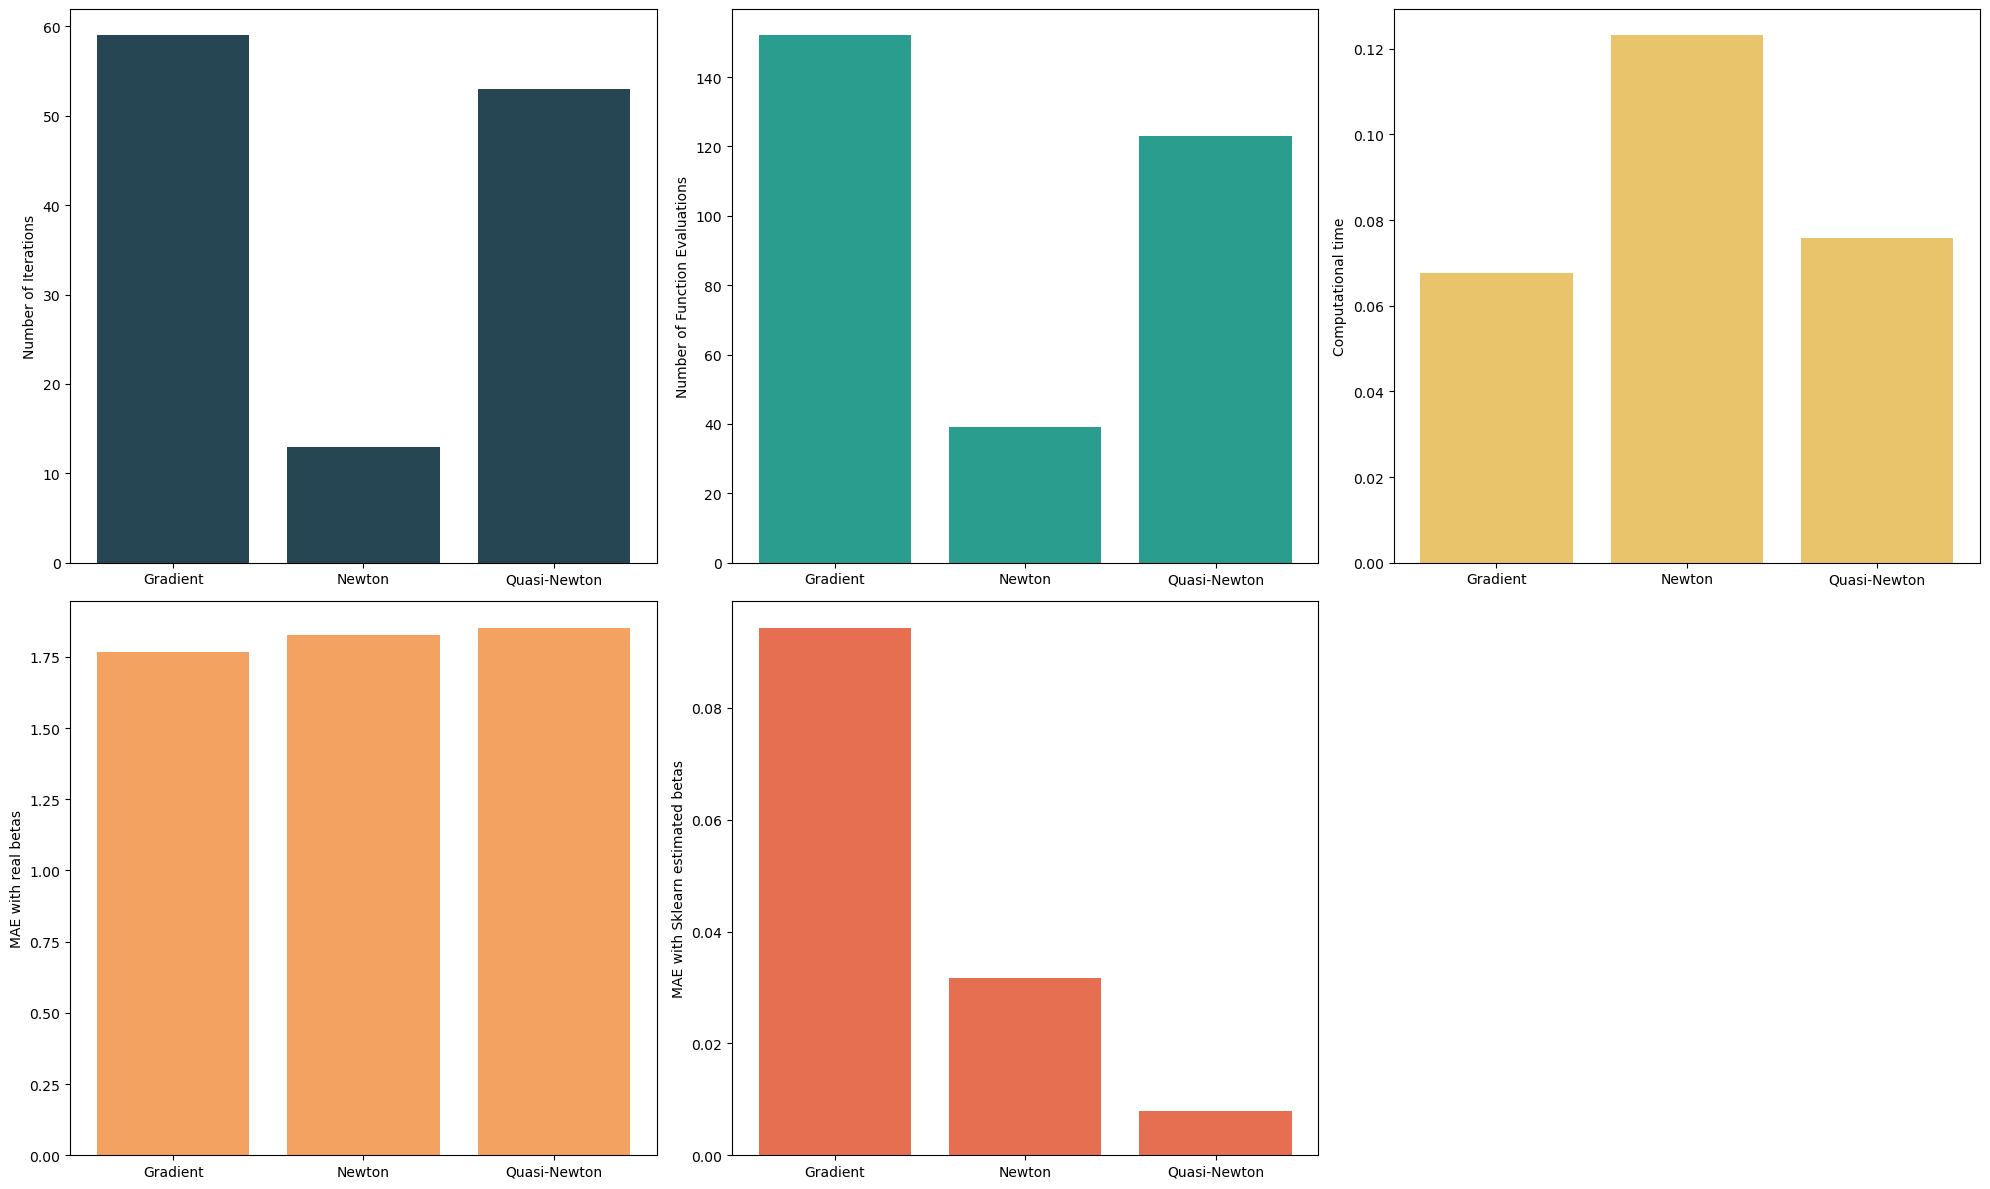

In [14]:
methods = ['Gradient', 'Newton', 'Quasi-Newton']
niter_values = [result_CG.nit, result_N.nit, result_BFGS.nit]
nfev_values =[result_CG.nfev, result_N.nfev, result_BFGS.nfev] 
comp_values = [elapsed_time_CG, elapsed_time_N, elapsed_time_BFGS] 
mae1_values = [metrics.mean_absolute_error(result_CG.x, beta), 
               metrics.mean_absolute_error(result_N.x, beta),  
               metrics.mean_absolute_error(result_BFGS.x, beta)] 
mae2_values = [metrics.mean_absolute_error(result_CG.x, model1.coef_[0]), 
               metrics.mean_absolute_error(result_N.x, model1.coef_[0]),
               metrics.mean_absolute_error(result_BFGS.x, model1.coef_[0])] 

# Plotting
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
fig.delaxes(ax[1, 2])

# Define colors
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

# Plot number of iterations
ax[0,0].bar(methods, niter_values, color=colors[0])
ax[0,0].set_ylabel('Number of Iterations')

# Plot number of function evaluations
ax[0,1].bar(methods, nfev_values, color=colors[1])
ax[0,1].set_ylabel('Number of Function Evaluations')

# Plot computational time
ax[0,2].bar(methods, comp_values, color=colors[2])
ax[0,2].set_ylabel('Computational time')

# Plot MAE with real betas
ax[1,0].bar(methods, mae1_values, color=colors[3])
ax[1,0].set_ylabel('MAE with real betas')

# Plot MAE with Sklearn estimated betas
ax[1,1].bar(methods, mae2_values, color=colors[4])
ax[1,1].set_ylabel('MAE with Sklearn estimated betas')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



#### Number of iterations

Attending to the number of iterations for which the different algorithms converged in the computation of $\beta$, we can see how the Newton method is the fastest in this aspect. This makes sense because it is the only method using the Hessian matrix so it has more information about function monotony. Both the Gradient and the Quasi-Newton needed more iterations.

#### Number of function and gradient evaluations

The fastest algorithm in terms of function evaluations was the Newton method. The results are very similar to the number of iterations ones.

#### Computational time

The fastest algorithm in terms of time was Quasi-Newton, followed by Gradient method and the Newton method. This makes sense because of the computational cost involded in the operations performed by each algorithm. This will be shown in next task.

#### Mean Absolute Error

We can analyze also the results in terms of the MAE. The error in all cases was fairly the same (low) value. This is an indicator of the robustness of the techiniques when compared winth both the real and the `Sklearn` estimations. All results are pretty balanced with the real betas and the with the `Sklearn` approach the best model was Quasi-Newton.

## Task D

*Estimate the value of the regression coefficients from \ref{eq:2} by implementing the:*
1. *Gradient method.*
2. *Newton method.*
3. *Quasi-Newton method.*

*Compare the performance of these algorithms (number of iterations and total computational time).*


Among all of the methods that exist in order to solve our optimization problem, some of them (that were conviently explained during the course) have easy implementations. Here we will explore the basic Gradient, Newton and BFGS Quasi-Newton methods (the simpler versions of the ones implemented in `Scipy` library).

All of these methods are iterative. This means they take an initial guess for their objective value and in each iteration the value is updated until they meet an stopping condition. Ideally, the stopping condition is that they have reached a convergence value[^3] (with a certain tolerance) or they have reached a maximum number of iterations (less convenient). 

[^3]: The convergence criterion will be the rate of change in the objective function beeing $<1e-6$. This is $\frac{f(x_k)-f(x_{k-1})}{||x_k-x_{k-1}||}<1\times 10^{-6}$. This means that the objective function value is no longer changing at sufficient speed to justify the next iteration of the model.

These three methods have in common that they are *descent direction methods*. This mean that in each iteration they walk in some direction of descent until they can't descend more. The parameters that determine how each algorithm 'descends' are: the search direction $p$ (how the descending direction is chosen) and the steplength $\alpha$ (how much you descend in each iteration).

Let $x_k$ be the optimal minimum value obtained by an algorithm in iteration $k$, then $x_{k+1}=x_{k}+\alpha_k p_k$. 
The steplength $\alpha$ is independent of the method used (even though it can be tuned using the Armijo rule) but what changes between methods is the descent direction $p$ selection.

### Gradient method

In mathematics, what is defined as the steepest direction of descent at point $x_k$ is know as the  negative gradient at point $x_k$, $-\nabla f(x_k)$. The gradient method takes this as descent direction for point $x_k$. 

The implementation of the method is:


In [15]:
def gradient_method(
    function,
    gradient,
    initial_guess,
    args=(), 
    alpha=0.01, 
    max_iter=100000, 
    tol=1e-6
):
    """
    Gradient method.

    Parameters:
    - function: the objective function.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization (needs to be a p+1 vector).
    - args: Additional arguments to be passed to gradient (default=()).
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=1000).
    - tol: Tolerance for convergence (default=1e-6).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    history = {"x": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))

    # Iterative process
    for i in range(max_iter):
        # Compute p
        p = -gradient(history["x"][i], *args)

        # Update parameter
        x_new = history["x"][i] + alpha * p

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(p))
        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, *args))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

### Newton method

The Newton method is a very well know method that is commonly used because it (theoretically) converges very fast eventhough its computational cost is higher than others. This is because it uses the Hessian Matrix. The descent direction it uses is: $p_k= -(\nabla^2f(x_k))^{-1}\nabla f(x_k)$.


The implementation of the method is:

In [16]:
def newton_method(
    function,
    gradient,
    hessian,
    initial_guess,
    args=(),
    alpha=0.01,
    max_iter=100000,
    tol=1e-6,
):
    """
    Newton's method.

    Parameters:
    - function: the objective function.
    - gradient: The gradient of the objective function.
    - hessian: The Hessian matrix of the objective function.
    - initial_guess: Initial guess for the optimization (needs to be a p+1 vector).
    - args: Additional arguments to be passed to gradient and hessian (default=()).
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=1000).
    - tol: Tolerance for convergence (default=1e-6).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    history = {"x": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))

    # Iterative process
    for i in range(max_iter):
        # Compute p
        p = -(np.linalg.inv(hessian(history["x"][i], *args))) @ gradient(
            history["x"][i], *args
        )

        # Update parameter
        x_new = history["x"][i] + alpha * p

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(p))
        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, *args))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

### Quasi-Newton method (BFGS)

Quasi Newton methods try to estimate $\nabla^2f(x_k)$ instead of using its analytical form. This way it's less computationally expensive because it uses only first derivatives with relativelly fast convergence. There are several ways to estimate the Hessian (all of them are mathematically complex), but the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm uses $p_k=-H_k \nabla f(x_k)$ with $H_k$ as an approximation for the inverse hessian at point $k$. This is:
$$H_{k+1}=\left(I-\frac{\Delta x_k y_k^{\mathrm{T}}}{y_k^{\mathrm{T}} \Delta x_k}\right) H_k\left(I-\frac{y_k \Delta x_k^{\mathrm{T}}}{y_k^{\mathrm{T}} \Delta x_k}\right)+\frac{\Delta x_k \Delta x_k^{\mathrm{T}}}{y_k^{\mathrm{T}} \Delta x_k}$$
with $y_k=\nabla f(x_{k+1})-\nabla f(x_k)$ and $\Delta x_k=x_{k+1}-x_k$.



The algorithm is:

In [17]:
def bfgs_method(
    function, 
    gradient, 
    initial_guess, 
    args=(), 
    alpha=0.01, 
    max_iter=100000, 
    tol=1e-6
):
    """
    BFGS method.

    Parameters:
    - function: the objective function.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization (needs to be a p+1 vector).
    - args: Additional arguments to be passed to gradient (default=()).
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=1000).
    - tol: Tolerance for convergence (default=1e-6).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    h = np.eye(len(x))  # Initial approximation of the Hessian inverse
    history = {"x": [], "fun": [], "gnorm": [], "h_values": []}
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    history["h_values"].append(h)

    # Iterative process
    for i in range(max_iter):
        # Update parameters
        p = -np.dot(history["h_values"][i], gradient(history["x"][i], *args))
        x_new = history["x"][i] + alpha * p
        d = x_new - history["x"][i]
        y = gradient(x_new, *args) - gradient(history["x"][i], *args)
        h_new = (np.eye(len(d)) - np.outer(d, y) / np.dot(y, d)) @ history["h_values"][
            i
        ] @ (np.eye(len(d)) - np.outer(y, d) / np.dot(y, d)) + (
            np.outer(d, d) / np.dot(y, d)
        )

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(p))
        history["h_values"].append(h_new)
        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, *args))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

### Estimation of $\beta$

We can now perform the estimation using the methods and compute some useful values.

In [18]:
# Gradient method
start_time = time.time()
beta_G, history_G, iter_G = gradient_method(
    function=neg_log_l,
    gradient=neg_log_l_gradient,
    initial_guess=initial_guess,
    args=(X, y),
)
end_time = time.time()
time_G = end_time - start_time


# Newton method
start_time = time.time()
beta_N, history_N, iter_N = newton_method(
    function=neg_log_l,
    gradient=neg_log_l_gradient,
    hessian=neg_log_l_hessian,
    initial_guess=initial_guess,
    args=(X, y),
)
end_time = time.time()
time_N = end_time - start_time

# BFGS method
start_time = time.time()
beta_BFGS, history_BFGS, iter_BFGS = bfgs_method(
    function=neg_log_l,
    gradient=neg_log_l_gradient,
    initial_guess=initial_guess,
    args=(X, y),
)
end_time = time.time()
time_BFGS = end_time - start_time

### Results

We now perform a similar analysis to the one in the previous section.

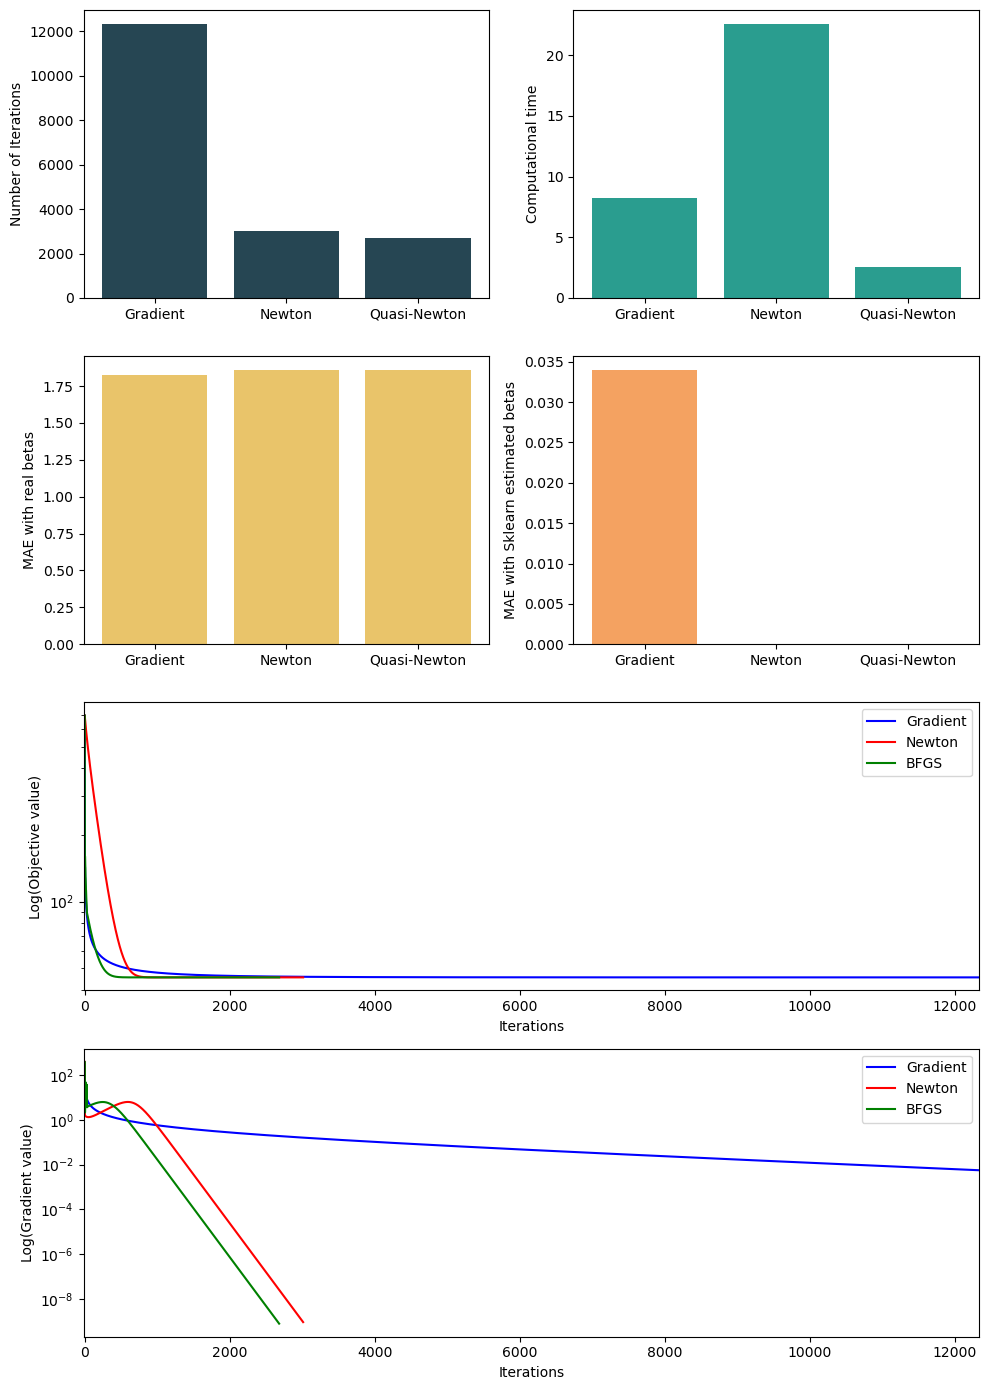

In [23]:
methods = ['Gradient', 'Newton', 'Quasi-Newton']
niter_values = [iter_G, iter_N, iter_BFGS]
comp_values = [time_G, time_N, time_BFGS] 
mae1_values = [metrics.mean_absolute_error(beta_G, beta), 
               metrics.mean_absolute_error(beta_N, beta),  
               metrics.mean_absolute_error(beta_BFGS, beta)]
mae2_values = [metrics.mean_absolute_error(beta_G, model1.coef_[0]), 
               metrics.mean_absolute_error(beta_N, model1.coef_[0]),
               metrics.mean_absolute_error(beta_BFGS, model1.coef_[0])] 
fun_values = [history_G['fun'], history_N['fun'], history_BFGS['fun']]
gnorm_values = [history_G['gnorm'], history_N['gnorm'], history_BFGS['gnorm']]

# Plotting
fig, ax = plt.subplot_mosaic("AB;CD;EE;FF",figsize=(10, 14))

# Plot number of iterations
ax['A'].bar(methods, niter_values, color=colors[0])
ax['A'].set_ylabel('Number of Iterations')

# Plot computational time
ax['B'].bar(methods, comp_values, color=colors[1])
ax['B'].set_ylabel('Computational time')

# Plot MAE with real betas
ax['C'].bar(methods, mae1_values, color=colors[2])
ax['C'].set_ylabel('MAE with real betas')

# Plot MAE with Sklearn estimated betas
ax['D'].bar(methods, mae2_values, color=colors[3])
ax['D'].set_ylabel('MAE with Sklearn estimated betas')

# Define colors for the curves
col = ['blue', 'red', 'green']
ax['E'].set_yscale('log', base=10)
# Iterate over lists and plot the curves
ax['E'].plot(fun_values[0], color=col[0], label='Gradient')
ax['E'].plot((fun_values[1]), color=col[1], label='Newton')
ax['E'].plot((fun_values[2]), color=col[2], label='BFGS')
# Add labels and legend
ax['E'].set_xlabel('Iterations')
ax['E'].set_ylabel('log(Objective value)')
ax['E'].legend()

ax['E'].set_xlim(-15,niter_values[0])


ax['F'].set_yscale('log', base=10)
# Iterate over lists A, B, and C and plot the curves
ax['F'].plot(gnorm_values[0], color=col[0], label='Gradient')
ax['F'].plot((gnorm_values[1]), color=col[1], label='Newton')
ax['F'].plot((gnorm_values[2]), color=col[2], label='BFGS')
# Add labels and legend
ax['F'].set_xlabel('Iterations')
ax['F'].set_ylabel('log(Gradient norm)')
ax['F'].legend()

ax['F'].set_xlim(-15,niter_values[0])



# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

It seems clear how the gradient method was the one performing more iterations. This means it is the slowest converging algorithm. In the other hand, this iterations are computationlly very fast, being the Gradient a lot faster than the Newton method (because of the extra computational complexity associated with the Hessian operations). We can see in the last two plots how the convergence of the Gradient method starts to decrease its speed and that's why it takes so much operations. Probably with less tolerance it will perform better. 

In terms of error, all methods behave fairly well achieving $<2$ MAE with the real betas. The Newton and Quasi-Newton approaches got almost $0$ MAE with `Sklearn`what indicates us that probably the library is using one of these methos to compute its solution.

## Task E

*Estimate the value of the regression coefficients from \ref{eq:2} by implementing the:*

1. *Coordinate gradient method.*
2. *Mini-batch gradient method. Study how the mini-batch size may impact the algorithm performance (number of iterations and computational time needed to reach a pre-specified tolerance limit).*
3. *Three other techniques presented in Topic 2 (one from each category: "noise reduction", "second-order" and "other" methods).*
4. *Invent your own descent algorithm (it can be a variation of one in iii). Be creative.*

A similar workflow as the one used in the prevoiuos task is used. Please note how the tolerance has been decreased to $1\times 10^{-3}$ because of computational reasons. Most of the results now presented should hold with smaller tolerances.

### Coordinate gradient method

The coordinate gradient descent method is an optimization algorithm that iteratively updates each coordinate of the parameter vector while keeping the others fixed. It is very useful when the number of observed variables $p$ is large.

The formulation is $x_{k+1}=x_k-\alpha_k\nabla_{i_k}f(x_k)e_{i_k},$

where $i_k$ is chosen randomly and $\nabla_{i_k}f(x_k)$ is the $i$-coordinate of the gradient vector.

The implementation is very similar to the Gradient method.

In [24]:
def coordinate_gradient(
    function, 
    gradient,
    initial_guess,
    args=(), 
    alpha=0.01, 
    max_iter=10000, 
    tol=1e-3
):
    """
    Coordinate gradient descent optimization method.

    Parameters:
    - objective_function: The objective function to be minimized.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization.
    - args: Additional arguments to be passed to gradient (default=())
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=10000).
    - tol: Tolerance for convergence (default=1e-3).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = np.array(initial_guess)
    history = {"x": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    n_variables = len(x)

    # Iterative process
    for i in range(max_iter):
        # Select a random coordinate to update
        j = np.random.randint(n_variables)
        e = np.zeros(n_variables)  # Create a vector of zeros
        e[j] = 1
        # Compute gradient with respect to the j-th coordinate
        grad = gradient(history["x"][i], *args)
        p = grad[j] * e
        # Update parameter
        x_new = history["x"][i] - alpha * p

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(p))
        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, *args))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

In [25]:
start_time = time.time()
beta_CoorG, history_CoorG, iter_CoorG = coordinate_gradient(
    neg_log_l, neg_log_l_gradient, initial_guess, args=(X, y)
)
end_time = time.time()
elapsed_time_CoorG = end_time - start_time

print("Optimization method: Coordinate Gradient")
print("Number of iterations:", iter_CoorG)
print("Computational time (seconds):", elapsed_time_CoorG)
print("Estimated coefficients:", beta_CoorG)
print("MAE with real betas:", metrics.mean_absolute_error(beta_CoorG, beta))
print("MAE with Sklearn betas estimation:",
       metrics.mean_absolute_error(beta_CoorG, model1.coef_[0]))

Optimization method: Coordinate Gradient
Number of iterations: 2137
Computational time (seconds): 1.3668220043182373
Estimated coefficients: [ 2.27601895  4.59878909 -2.10580168  0.9183348   2.22785644  3.62720152
 -0.49212237  0.54731051  1.29552177  3.08852528 -2.6118664   3.0466647
 -0.81696139  2.68907249  3.77936163  3.02692519  1.14677346 -2.54101138
 -3.80772012 -2.09122466 -3.28477692]
MAE with real betas: 2.332388536562538
MAE with Sklearn betas estimation: 4.191936670656086


### Mini-batch gradient descent

The Mini-batch gradient descent is the state-of-art in Deep Learning libraries. It combines the best of stochastic gradient when n is large as well as a reduction of the variance in the estimator of the gradient by the introduction of the mini-batches instead of the 1-point estimation.

The iterative formula is: 
$x_{k+1} = x_k - \frac{\alpha_k}{|S_k|} \sum_{i \in S_k} \nabla f_i(x_k)$

Where $S_k=1, \ldots, t$ is the index of the minibatches created in each iteration and $\nabla f_i(x_k)$ is the gradient function computed only for batch $i$.

This can be implemented:

In [26]:
def miniBatch_gradient(
    function,
    gradient,
    initial_guess,
    batch_size=128,
    args=(),
    alpha=0.01,
    max_iter=10000,
    tol=1e-6,
):
    """
    Mini-batch gradient descent optimization method.

    Parameters:
    - function: The objective function to be minimized.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization.
    - batch_size: Number of samples per batch (default=128).
    - args: Additional arguments to be passed to gradient (default=())
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=10000).
    - tol: Tolerance for convergence (default=1e-3).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    history = {"x": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    i = 0
    X = args[0]
    y = args[1]

    # Calculate all possible (max_iter) samples to not make random choices in loops
    subsets = np.random.choice([x for x in range(0, X.shape[0])], max_iter * batch_size)
    subsets.resize(max_iter, batch_size)

    # Iterative process
    for i in range(max_iter):
        # Create batch
        sample = subsets[i]

        # Compute p
        p = gradient(history["x"][i], X[sample], y[sample])

        # Update parameter
        x_new = history["x"][i] - alpha * p

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(p))
        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, X[sample], y[sample]))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

In [27]:
start_time = time.time()
beta_miniB, history_miniB, iter_miniB = miniBatch_gradient(
    function=neg_log_l,
    gradient=neg_log_l_gradient,
    initial_guess=initial_guess,
    args=(X, y),
)
end_time = time.time()
elapsed_time_miniB = end_time - start_time

print("Optimization method: Mini-batch gradient descent")
print("Number of iterations:", iter_miniB)
print("Computational time (seconds):", elapsed_time_miniB)
print("Estimated coefficients:", beta_miniB)
print("MAE with real betas: ", metrics.mean_absolute_error(beta_miniB, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(beta_miniB, model1.coef_[0]))

Optimization method: Mini-batch gradient descent
Number of iterations: 9999
Computational time (seconds): 5.83292818069458
Estimated coefficients: [ 4.90926361  9.42735391 -4.22048387  1.79493789  4.56770358  7.16188461
 -0.97336284  1.03533542  2.66291629  6.22274365 -5.38429634  6.28092466
 -1.46025842  5.51523788  8.06187021  6.28940523  2.50248626 -5.20802377
 -7.67771969 -4.28645851 -6.83690812]
MAE with real betas:  0.2837992041673096
MAE with Sklearn betas estimation:  1.6938540990557012


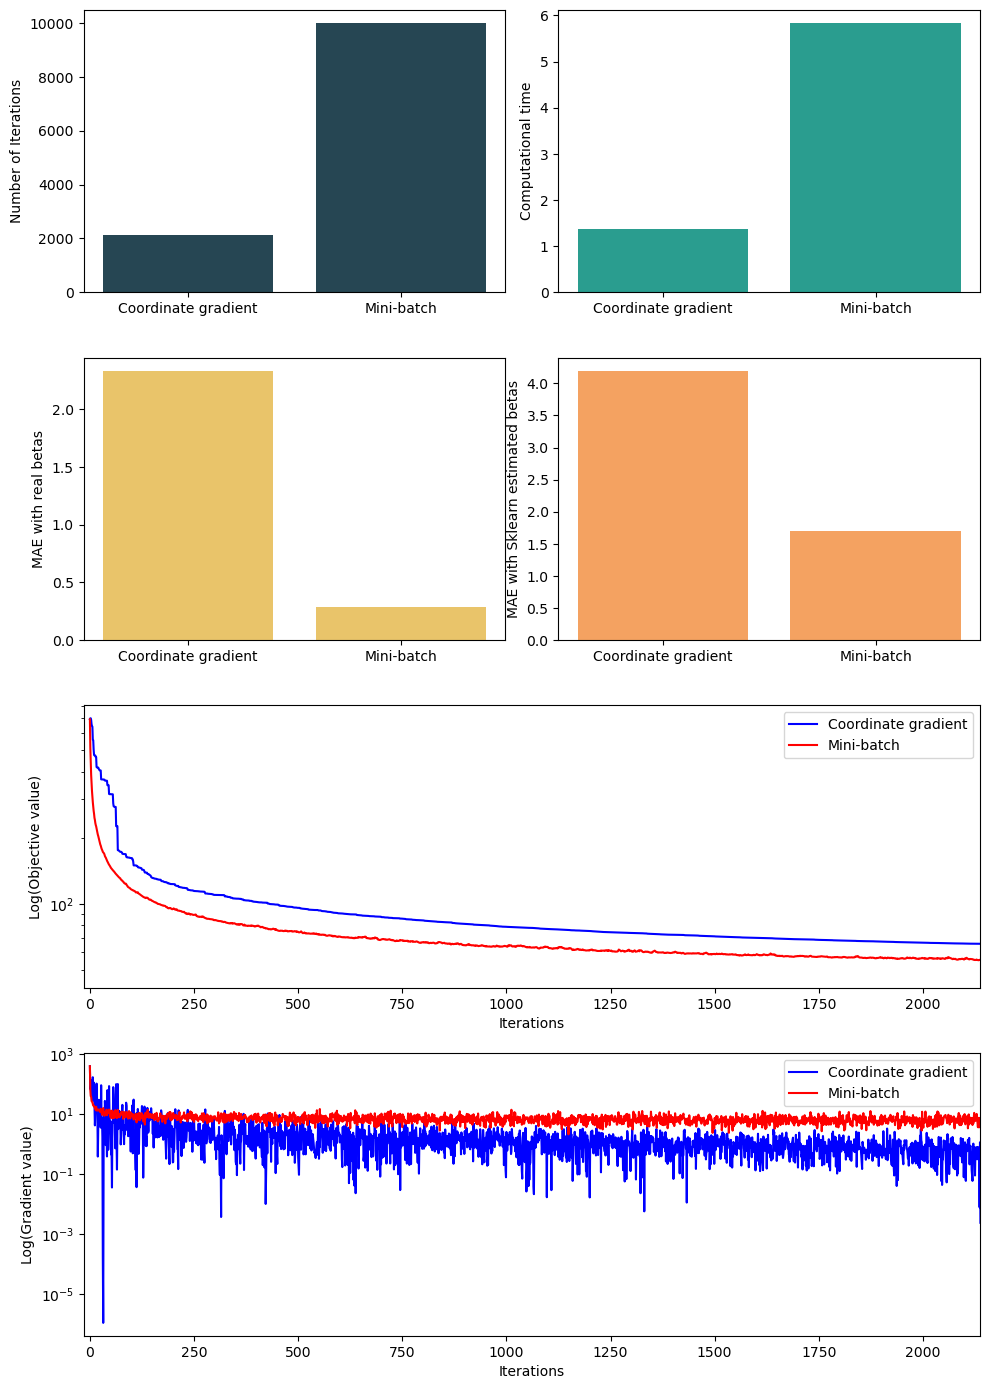

In [28]:
methods = ['Coordinate gradient', 'Mini-batch']
niter_values = [iter_CoorG, iter_miniB]
comp_values = [elapsed_time_CoorG, elapsed_time_miniB] 
mae1_values = [metrics.mean_absolute_error(beta_CoorG, beta), 
               metrics.mean_absolute_error(beta_miniB, beta)]
mae2_values = [metrics.mean_absolute_error(beta_CoorG, model1.coef_[0]), 
               metrics.mean_absolute_error(beta_miniB, model1.coef_[0])] 
fun_values = [history_CoorG['fun'], history_miniB['fun']]
gnorm_values = [history_CoorG['gnorm'], history_miniB['gnorm']]

# Plotting
fig, ax = plt.subplot_mosaic("AB;CD;EE;FF",figsize=(10, 14))

# Plot number of iterations
ax['A'].bar(methods, niter_values, color=colors[0])
ax['A'].set_ylabel('Number of Iterations')

# Plot computational time
ax['B'].bar(methods, comp_values, color=colors[1])
ax['B'].set_ylabel('Computational time')

# Plot MAE with real betas
ax['C'].bar(methods, mae1_values, color=colors[2])
ax['C'].set_ylabel('MAE with real betas')

# Plot MAE with Sklearn estimated betas
ax['D'].bar(methods, mae2_values, color=colors[3])
ax['D'].set_ylabel('MAE with Sklearn estimated betas')

# Define colors for the curves
col = ['blue', 'red', 'green']
ax['E'].set_yscale('log', base=10)
# Iterate over lists and plot the curves
ax['E'].plot(fun_values[0], color=col[0], label='Coordinate gradient')
ax['E'].plot((fun_values[1]), color=col[1], label='Mini-batch')

# Add labels and legend
ax['E'].set_xlabel('Iterations')
ax['E'].set_ylabel('log(Objective value)')
ax['E'].legend()

ax['E'].set_xlim(-15,niter_values[0])


ax['F'].set_yscale('log', base=10)
# Iterate over lists A, B, and C and plot the curves
ax['F'].plot(gnorm_values[0], color=col[0], label='Coordinate gradient')
ax['F'].plot((gnorm_values[1]), color=col[1], label='Mini-batch')
# Add labels and legend
ax['F'].set_xlabel('Iterations')
ax['F'].set_ylabel('log(Gradient norm)')
ax['F'].legend()

ax['F'].set_xlim(-15,niter_values[0])



# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Please note how the Mini-Batch method is peaking the number of iterations, so maybe some more precission is left in the run. Here we see how the gradient method isn't consistent at minimizing the gradient norm because of only changing one dimension at a time. The objective function is still decreased but slower tan mini-batch method.

When dealing with Mini-batch optimization the size of the batch always is something we have to decide. This can be done via Cross Validation. Small batches will reduce the computational cost by increasing the variance and big batches the other way around. At the end of the day is a matter of trade off. We try some different batches size now:

In [22]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512]
time_sizes = []
iter_sizes = []
mae_sizes = []
for elem in batch_sizes:
    start_time = time.time()
    beta_miniB, history_miniB, iter_miniB = miniBatch_gradient(
        neg_log_l, neg_log_l_gradient, initial_guess, batch_size=elem, args=(X, y)
    )
    end_time = time.time()
    elapsed = end_time - start_time
    time_sizes.append(elapsed)
    iter_sizes.append(iter_miniB)
    mae_sizes.append(metrics.mean_absolute_error(beta_miniB, beta))

# Print the results
print("The computation time sequence is: ", time_sizes)
print("The iteration increase is: ", iter_sizes)
print("The mae sequence is: ", mae_sizes)

The computation time sequence is:  [2.0906431674957275, 2.1259548664093018, 2.144477128982544, 2.1362709999084473, 2.2413651943206787, 2.2339155673980713, 2.5778281688690186, 2.7415261268615723, 3.3187010288238525]
The iteration increase is:  [9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999]
The mae sequence is:  [4.196273373937179, 3.9973481595217026, 3.7584687785055193, 3.4670463050610283, 3.117699629135945, 2.6883557844588473, 2.1797810184505537, 1.582870697585581, 0.9177030556452966]


The results arise that the computational time goes up when you increase the batch size (because of the gradient computation been more complex) and so does the convergence. We can see how the MAE decreases for every batch size.

### Three other techniques

#### Noise Reduction: Dynamic Sampling

Even though Mini-batch is a noise reduction techinique (helping Stochastic ideas), this noise reduction can be improved by gradually increasing the minibatch size used in the gradient computation, thus employing increasingly more accurate gradient estimates as the optimization process proceeds. 

This can be easilly achieved with a geometric sequence in the batch size. Here we implement a version with a initial 100 batch with $5\%$ increment per iteration until max batch size possible, but the batch size and increment can both be adjusted as in the last task.



In [29]:
def miniBatch_dynamic(
    function,
    gradient,
    initial_guess,
    batch_size=32,
    args=(),
    alpha=0.01,
    max_iter=10000,
    tol=1e-3,
    dynamic_batch=True,
):
    """
    Mini-batch gradient descent optimization method with dynamic batch size.

    Parameters:
    - function: The objective function to be minimized.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization.
    - batch_size: Initial number of samples per batch (default=32).
    - args: Additional arguments to be passed to gradient (default=()).
    - alpha: The step length for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=10000).
    - tol: Tolerance for convergence (default=1e-6).
    - dynamic_batch: If True, dynamically adjusts the batch size (default=True).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    - i: Number of iterations performed.
    """

    # Initialize variables
    x = initial_guess
    history = {"x": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    X = args[0]
    y = args[1]

    # Iterative process
    for i in range(max_iter):
        # Dynamic batch size adjustment
        if dynamic_batch:
            batch_size = int(
                min(1000, batch_size * 1.05)
            )  # Adjust batch size dynamically 5%

        # Create batch
        sample = np.random.choice(X.shape[0], batch_size, replace=False)

        # Compute p
        p = -gradient(history["x"][i], X[sample], y[sample])

        # Update parameter
        x_new = history["x"][i] + alpha * p

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(gradient(x_new, *args)))
        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, X[sample], y[sample]))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

In [30]:
start_time = time.time()
beta_Dy, history_Dy, iter_Dy = miniBatch_dynamic(
    neg_log_l, gradient=neg_log_l_gradient, initial_guess=initial_guess, args=(X, y)
)
end_time = time.time()
elapsed_time_Dy = end_time - start_time

print("Optimization method: Dynamic Sample mini-batch gradient descent")
print("Number of iterations:", iter_Dy)
print("Computational time (seconds):", elapsed_time_Dy)
print("Estimated coefficients:", beta_Dy)
print("MAE with real betas: ", metrics.mean_absolute_error(beta_Dy, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(beta_Dy, model1.coef_[0]))

Optimization method: Dynamic Sample mini-batch gradient descent
Number of iterations: 9999
Computational time (seconds): 11.549180030822754
Estimated coefficients: [  6.49284383  12.38103061  -5.59000184   2.34742272   6.16641534
   9.25563593  -1.21948771   1.44957685   3.48803861   8.30815533
  -7.38328973   8.31780688  -2.04323551   7.46914731  10.78010074
   8.39909918   3.45751567  -6.98522858 -10.21824828  -5.74048954
  -9.00134047]
MAE with real betas:  1.7854338416180777
MAE with Sklearn betas estimation:  0.07411429247547097


#### Second order method: Stochastic Quasi-Newton

This method combines the stochastic procedure (estimating only the gradient with one random element in each iteration) with the hessian estimation of the Quasi-Newton method. The code is:

In [31]:
def bfgs_stoch_method(
    function, 
    gradient, 
    initial_guess, 
    args=(), 
    alpha=0.01, 
    max_iter=10000, 
    tol=1e-3
):
    """
    BFGS method.

    Parameters:
    - function: the objective function.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization (needs to be a p+1 vector).
    - args: Additional arguments to be passed to gradient (default=()).
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=10000).
    - tol: Tolerance for convergence (default=1e-3).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    h = np.eye(len(x))  # Initial approximation of the Hessian inverse
    history = {"x": [], "h_values": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["h_values"].append(h)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    X = args[0]
    y = args[1]

    # Iterative process
    for i in range(max_iter):
        # Stochastic selection
        sample = np.random.choice(X.shape[0], 1, replace=False)

        # Compute p
        grad = gradient(history["x"][i], X[sample], y[sample])
        # Update parameters
        p = -np.dot(history["h_values"][i], grad)
        x_new = history["x"][i] + alpha * p
        d = x_new - history["x"][i]
        ay = gradient(x_new, X[sample], y[sample]) - gradient(
            history["x"][i], X[sample], y[sample]
        )
        h_new = (np.eye(len(d)) - np.outer(d, ay) / np.dot(ay, d)) @ history[
            "h_values"
        ][i] @ (np.eye(len(d)) - np.outer(ay, d) / np.dot(ay, d)) + (
            np.outer(d, d) / np.dot(ay, d)
        )

        if np.dot(ay, d) != 0:  # avoid nan if ortogonal
            # Update history
            history["x"].append(x_new)
            history["h_values"].append(h_new)
            history["fun"].append(function(x_new, *args))
            history["gnorm"].append(np.linalg.norm(grad))
            beta = x_new
        else:
            history["x"].append(x)
            history["h_values"].append(h)
            history["fun"].append(function(x, *args))
            history["gnorm"].append(np.linalg.norm(grad))
            beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, X[sample], y[sample]))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break

    return beta, history, i

In [32]:
start_time = time.time()
beta_SQN, history_SQN, iter_SQN = bfgs_stoch_method(
    neg_log_l, neg_log_l_gradient, initial_guess, args=(X, y)
)
end_time = time.time()
elapsed_time_SQN = end_time - start_time

print("Optimization method: Stochastic Quasi-Newton method")
print("Number of iterations:", iter_SQN)
print("Computational time (seconds):", elapsed_time_SQN)
print("Estimated coefficients:", beta_SQN)
print("MAE with real betas: ", metrics.mean_absolute_error(beta_SQN, beta))
print(    "MAE with Sklearn betas estimation: ",
    metrics.mean_absolute_error(beta_SQN, model1.coef_[0]))

C:\Users\marco\AppData\Local\Temp\ipykernel_19700\1372404478.py:52: RuntimeWarning: invalid value encountered in divide
  h_new = (np.eye(len(d)) - np.outer(d, ay) / np.dot(ay, d)) @ history[
C:\Users\marco\AppData\Local\Temp\ipykernel_19700\1372404478.py:54: RuntimeWarning: invalid value encountered in divide
  ][i] @ (np.eye(len(d)) - np.outer(ay, d) / np.dot(ay, d)) + (
C:\Users\marco\AppData\Local\Temp\ipykernel_19700\1372404478.py:55: RuntimeWarning: invalid value encountered in divide
  np.outer(d, d) / np.dot(ay, d)
C:\Users\marco\AppData\Local\Temp\ipykernel_19700\1372404478.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  (history["fun"][i] - function(x_new, X[sample], y[sample]))
C:\Users\marco\AppData\Local\Temp\ipykernel_19700\1372404478.py:55: RuntimeWarning: divide by zero encountered in divide
  np.outer(d, d) / np.dot(ay, d)


Optimization method: Stochastic Quasi-Newton method
Number of iterations: 9999
Computational time (seconds): 8.940794944763184
Estimated coefficients: [ 0.80876903  1.16322417 -0.81570701  0.1100091   1.30931017  0.9845139
  0.14456614  0.51225686  0.26974087  0.85630393 -0.68692392  0.53495746
 -0.12185512  0.53583416  0.70574742  0.31406715  0.74072151 -0.78404034
 -1.00636791 -0.61669325 -1.02035999]
MAE with real betas:  4.059388707651092
MAE with Sklearn betas estimation:  5.91893684174464


#### Other methods: Momentum method

This method uses the momentum (direction 'trend' of the gradient in the last iterations) in order to enhance the convergence. This idea may lead to lack of theoretical convergence but has very good results in depp-learning experimental performance. 

The idea is to select $\beta_k$ a momentum parameter and compute $x_{k+1}=x_k - \alpha \nabla f(x_k) + \beta_k (x_k - x_{k-1})$.

This is presented with descent gradient technique but this can be combined with all the rest of techniques.

In [33]:
def momentum_method(
    function,
    gradient,
    initial_guess,
    args=(),
    alpha=0.01,
    b_m=0.1,
    max_iter=10000,
    tol=1e-3,
):
    """
    Momentum method.

    Parameters:
    - function: the objective function.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization (needs to be a p+1 vector).
    - args: Additional arguments to be passed to gradient (default=()).
    - alpha: The step length for the algorithm (default=0.01).
    - b_m: The momentum parameter (default=0.1).
    - max_iter: Maximum number of iterations (default=1000).
    - tol: Tolerance for convergence (default=1e-3).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    m = np.zeros_like(x)  # Momentum term
    history = {"x": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["x"].append(x)
    history["fun"].append(function(x, *args))
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))

    # Iterative process
    for i in range(max_iter):
        # Compute gradient
        grad = gradient(history["x"][i + 1], *args)

        # Update momentum
        m = b_m * (history["x"][i + 1] - history["x"][i])

        # Update parameter
        x_new = history["x"][i + 1] - alpha * grad + m

        # Update history
        history["x"].append(x_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(grad))

        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i + 1] - function(x_new, *args))
                / np.linalg.norm(history["x"][i + 1] - x_new)
            )
            < tol
        ):
            break
    return beta, history, i

In [34]:
start_time = time.time()
beta_Mom, history_Mom, iter_Mom = momentum_method(
    neg_log_l, neg_log_l_gradient, initial_guess, args=(X, y)
)
end_time = time.time()
elapsed_time_Mom = end_time - start_time

print("Optimization method: Momemtum method")
print("Number of iterations:", iter_Mom)
print("Computational time (seconds):", elapsed_time_Mom)
print("Estimated coefficients:", beta_Mom)
print("MAE with real betas: ", metrics.mean_absolute_error(beta_Mom, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(beta_Mom, model1.coef_[0]))

Optimization method: Momemtum method
Number of iterations: 9999
Computational time (seconds): 6.256668329238892
Estimated coefficients: [  6.5171367   12.42522338  -5.60965677   2.3557781    6.18927874
   9.28747746  -1.22353744   1.45443476   3.50025687   8.33836115
  -7.41061131   8.34790511  -2.05021984   7.49638984  10.8200257
   8.4297554    3.47073413  -7.0112523  -10.2553275   -5.76130336
  -9.03415503]
MAE with real betas:  1.8089914698315288
MAE with Sklearn betas estimation:  0.05055666426201998


### Own method: Quasi-Newton Dynamic sample Mini Batch

Here we present our own combination of method. The idea is to combine the Quasi-Newton approximation with BFGS formula with the dynamic sampling idea in order to increasingly create better and better approximations but making the first computations faster.

Our proposal is the following:

In [35]:
def bfgs_dynamic_method(
    function,
    gradient,
    initial_guess,
    args=(),
    batch_size=128,
    alpha=0.01,
    max_iter=10000,
    tol=1e-3,
    dynamic_batch=True,
):
    """
    BFGS method.

    Parameters:
    - function: the objective function.
    - gradient: The gradient of the objective function.
    - initial_guess: Initial guess for the optimization (needs to be a p+1 vector).
    - args: Additional arguments to be passed to gradient (default=()).
    - alpha: The steplegth for the algorithm (default=0.01).
    - max_iter: Maximum number of iterations (default=10000).
    - tol: Tolerance for convergence (default=1e-6).
    - batch_size: Initial number of samples per batch (default=128).
    - dynamic_batch: If True, dynamically adjusts the batch size (default=True).

    Returns:
    - result: The optimized parameter values.
    - history: A dictionary containing the optimization history.
    """

    # Initialize variables
    x = initial_guess
    h = np.eye(len(x))  # Initial approximation of the Hessian inverse
    history = {"x": [], "h_values": [], "fun": [], "gnorm": []}
    history["x"].append(x)
    history["h_values"].append(h)
    history["fun"].append(function(x, *args))
    history["gnorm"].append(np.linalg.norm(gradient(x, *args)))
    X = args[0]
    y = args[1]

    # Iterative process
    for i in range(max_iter):

        if dynamic_batch:
            batch_size = int(
                min(1000, batch_size * 1.05)
            )  # Adjust batch size dynamically 5%
        # Stochastic selection
        sample = np.random.choice(X.shape[0], batch_size, replace=False)

        # Update parameters
        grad = gradient(history["x"][i], X[sample], y[sample])
        p = -np.dot(history["h_values"][i], grad)
        x_new = history["x"][i] + alpha * p
        grad_new = gradient(x_new, X[sample], y[sample])
        d = x_new - history["x"][i]
        ay = grad_new - grad
        h_new = (np.eye(len(d)) - np.outer(d, ay) / np.dot(ay, d)) @ history[
            "h_values"
        ][i] @ (np.eye(len(d)) - np.outer(ay, d) / np.dot(ay, d)) + (
            np.outer(d, d) / np.dot(ay, d)
        )

        # Update history
        history["x"].append(x_new)
        history["h_values"].append(h_new)
        history["fun"].append(function(x_new, *args))
        history["gnorm"].append(np.linalg.norm(grad))

        beta = x_new

        # Check for convergence
        if (
            np.linalg.norm(
                (history["fun"][i] - function(x_new, X[sample], y[sample]))
                / np.linalg.norm(history["x"][i] - x_new)
            )
            < tol
        ):
            break

    return beta, history, i

In [36]:
start_time = time.time()
beta_own, history_own, iter_own = bfgs_dynamic_method(
    neg_log_l, neg_log_l_gradient, initial_guess, args=(X, y), dynamic_batch=True
)
end_time = time.time()
elapsed_time_own = end_time - start_time

print("Optimization method: Quasi-Newton with dynamic batch size method")
print("Number of iterations:", iter_own)
print("Computational time (seconds):", elapsed_time_own)
print("Estimated coefficients:", beta_own)
print("MAE with real betas: ", metrics.mean_absolute_error(beta_own, beta))
print("MAE with Sklearn betas estimation: ",
       metrics.mean_absolute_error(beta_own, model1.coef_[0]))

Optimization method: Quasi-Newton with dynamic batch size method
Number of iterations: 980
Computational time (seconds): 1.4505815505981445
Estimated coefficients: [  6.52839812  12.44552926  -5.61857098   2.35951301   6.19958501
   9.30233576  -1.22526623   1.4568148    3.50600089   8.35219412
  -7.42313803   8.361748    -2.05335196   7.50888243  10.83844937
   8.44376583   3.47679067  -7.02312995 -10.27233164  -5.77064067
  -9.04930979]
MAE with real betas:  1.8197974535504398
MAE with Sklearn betas estimation:  0.03975068054310885


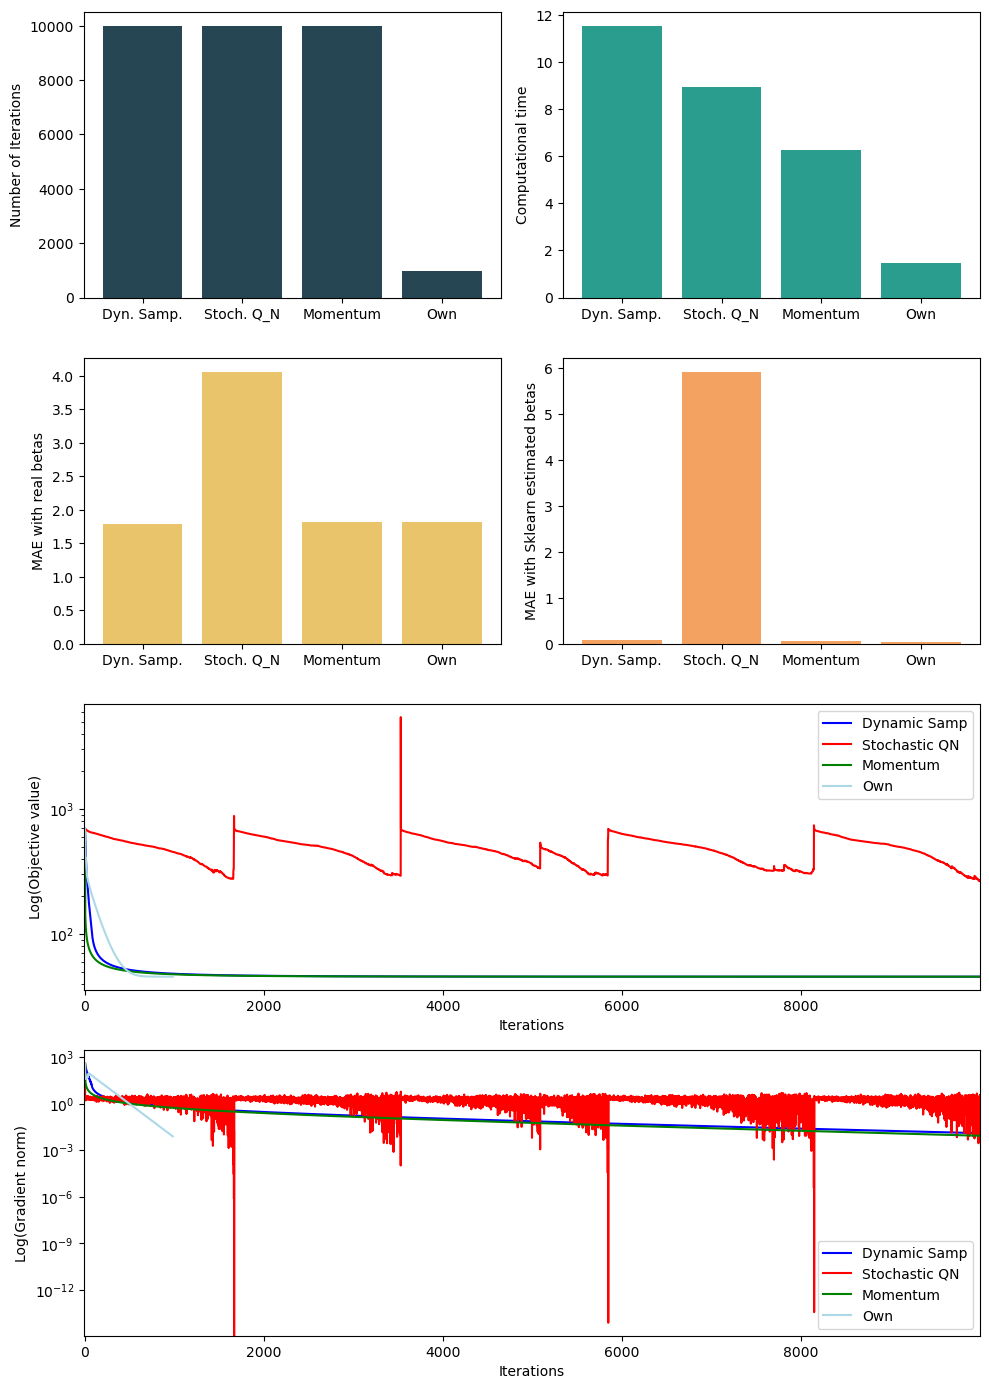

In [38]:
methods = ['Dyn. Samp.', 'Stoch. Q_N', 'Momentum', 'Own']
niter_values = [iter_Dy, iter_SQN, iter_Mom, iter_own]
comp_values = [elapsed_time_Dy, elapsed_time_SQN, elapsed_time_Mom,elapsed_time_own] 
mae1_values = [metrics.mean_absolute_error(beta_Dy, beta), 
               metrics.mean_absolute_error(beta_SQN, beta),
               metrics.mean_absolute_error(beta_Mom, beta),
              metrics.mean_absolute_error(beta_own, beta)]
mae2_values = [metrics.mean_absolute_error(beta_Dy, model1.coef_[0]), 
               metrics.mean_absolute_error(beta_SQN, model1.coef_[0]),
              metrics.mean_absolute_error(beta_Mom, model1.coef_[0]),
              metrics.mean_absolute_error(beta_own, model1.coef_[0])] 
fun_values = [history_Dy['fun'], history_SQN['fun'],history_Mom['fun'],history_own['fun']]
gnorm_values = [history_Dy['gnorm'], history_SQN['gnorm'],history_Mom['gnorm'],history_own['gnorm']]

# Plotting
fig, ax = plt.subplot_mosaic("AB;CD;EE;FF",figsize=(10, 14))

# Plot number of iterations
ax['A'].bar(methods, niter_values, color=colors[0])
ax['A'].set_ylabel('Number of Iterations')

# Plot computational time
ax['B'].bar(methods, comp_values, color=colors[1])
ax['B'].set_ylabel('Computational time')

# Plot MAE with real betas
ax['C'].bar(methods, mae1_values, color=colors[2])
ax['C'].set_ylabel('MAE with real betas')

# Plot MAE with Sklearn estimated betas
ax['D'].bar(methods, mae2_values, color=colors[3])
ax['D'].set_ylabel('MAE with Sklearn estimated betas')

# Define colors for the curves
col = ['blue', 'red', 'green', 'lightblue']
ax['E'].set_yscale('log', base=10)
# Iterate over lists and plot the curves
ax['E'].plot(fun_values[0], color=col[0], label='Dynamic Samp')
ax['E'].plot((fun_values[1]), color=col[1], label='Stochastic QN')
ax['E'].plot((fun_values[2]), color=col[2], label='Momentum')
ax['E'].plot((fun_values[3]), color=col[3], label='Own')

# Add labels and legend
ax['E'].set_xlabel('Iterations')
ax['E'].set_ylabel('Log(Objective value)')
ax['E'].legend()

ax['E'].set_xlim(-15,niter_values[0])


ax['F'].set_yscale('log', base=10)
# Iterate over lists A, B, and C and plot the curves
ax['F'].plot(gnorm_values[0], color=col[0], label='Dynamic Samp')
ax['F'].plot((gnorm_values[1]), color=col[1], label='Stochastic QN')
ax['F'].plot((gnorm_values[2]), color=col[2], label='Momentum')
ax['F'].plot((gnorm_values[3]), color=col[3], label='Own')
# Add labels and legend
ax['F'].set_xlabel('Iterations')
ax['F'].set_ylabel('Log(Gradient norm)')
ax['F'].legend()

ax['F'].set_xlim(-15,niter_values[0])



# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

It seems clear how the first three methods are reaching maximum number of iterations, being the slowest in computational time Dynamic Sampling. If we check the last tweo plots we can see how for Dynamic Sampling and Momentum, a real decrease in objective value and gradient norm is achieved, and the reason to go to maximum iterations is this decresae not been enough to meet the algorithm stopping condition. This is not the case of Stochastic Quasi Newton that has an erratic  behaviour (probably the reason is some error in the implementation). 

Our own method combines the techniques that have less error in the previous tasks achieving (as we thougth) a very good approximation with a reduced computational cost thanks to the mini-batch and dynamic sampling.

## Task F

*Consider the constrained problem:*
$$
\begin{aligned}
\max _\beta & \sum_{i=1}^n y_i \log \varphi\left(\beta ; x_i\right)+\sum_{i=1}^n\left(1-y_i\right) \log \left(1-\varphi\left(\beta ; x_i\right)\right) \\
\text { s.t. } & \sum_{j=0}^p \beta_j^2=100
\end{aligned}
$$

*Estimate the optimal value of the regression coefficients by implementing a penalization algorithm.*

Using the penalization problem formulation seen in class, we have that the previous problem can be written as (assuming max log-likelihood is changed for min negative log-likelihood):


$$\min _\beta -\biggl(\sum_{i=1}^n y_i \log \varphi\left(\beta;x_i\right)+\sum_{i=1}^n\left(1-y_i\right) \log \left(1-\varphi\left(\beta ; x_i\right)\right)\biggr) + \frac{\rho}{2}(\langle\beta_j,\beta_j^t\rangle-100)^2$$

In [34]:
def const_fun(beta, X, y, rho):
    return neg_log_l(beta, X, y) + (rho / 2) * (np.dot(beta, beta.T) - 100) ** 2

This way the gradient of the first component is the defined `neg_log_l_gradient` and the gradient of the second part is:
$$\nabla c = 2\rho \beta(\sum \beta^2 -100)$$

In [35]:
# Gradient
def const_gradient(beta, X, y, rho):
    return neg_log_l_gradient(beta, X, y) + 2 * rho * beta * (
        np.dot(beta, beta.T) - 100
    )

We can optimize this using Gradient descent method:

In [36]:
start_time = time.time()
beta_cons, history_cons, iter_cons = gradient_method(
    function=const_fun,
    gradient=const_gradient,
    initial_guess=initial_guess,
    args=(X, y, 0.003),
    max_iter=10000,
    tol=1e-6,
)
end_time = time.time()
elapsed_time_cons = end_time - start_time

print("Constrained optimization problem")
print("Number of iterations:", iter_cons)
print("Computational time (seconds):", elapsed_time_cons)
print("Estimated coefficients:", beta_cons)

Constrained optimization problem
Number of iterations: 950
Computational time (seconds): 0.2998056411743164
Estimated coefficients: [ 2.29620921  4.65302479 -2.12271617  0.91816431  2.24251407  3.64540332
 -0.49552981  0.5537285   1.30570108  3.10200709 -2.63927875  3.06895053
 -0.81528088  2.70712267  3.87026942  3.07038748  1.1551655  -2.56097775
 -3.8258197  -2.10462693 -3.30040977]


In [46]:
result_cons = minimize(
    const_fun,
    jac=const_gradient,
    method="trust-constr",
    x0=initial_guess,
    args=(X, y, 0.003),
    constraints={"type": "eq", "fun": lambda beta: np.sum(beta**2) - 100},
)

metrics.mean_absolute_error(beta_cons, result_cons.x)

0.4353906940906607